In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL
import tensorflow as tf

In [2]:
import pathlib
path = r'C:\Users\user\Downloads\malaria\cell_images\cell_images'
data_dir = pathlib.Path(path).with_suffix('')


In [4]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

27558


In [5]:
uninfected = list(data_dir.glob("Uninfected/*"))
parasitized = list(data_dir.glob("Parasitized/*"))
print("Number of uninfected cells", len(uninfected))
print("Number of infected cells", len(parasitized))

Number of uninfected cells 13780
Number of infected cells 13780


Display some of the cells examples

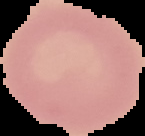

In [6]:
PIL.Image.open(uninfected[1])

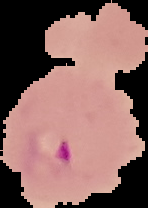

In [7]:
PIL.Image.open(parasitized[1])

In [8]:
batch_size = 32
img_height = 150
img_width = 150

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split = 0.3,
    rescale = 1/255
)

In [11]:
training_data = image_gen.flow_from_directory(
    data_dir,
    subset = "training",
    class_mode="binary",
    target_size = (img_width, img_height),
    batch_size = batch_size
)

validation_data = image_gen.flow_from_directory(
    data_dir,
    subset = "validation",
    class_mode="binary",
    target_size = (img_width, img_height),
    batch_size = batch_size
)

Found 19292 images belonging to 2 classes.
Found 8266 images belonging to 2 classes.


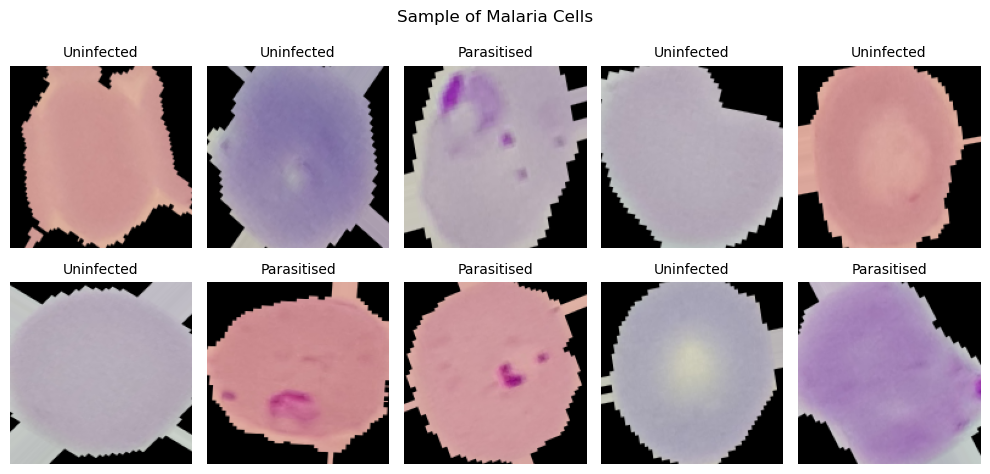

In [12]:
X_train, y_train = next(training_data)

fig = plt.figure(figsize=(10, 5))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(X_train[i]) #shows the ith image
    ax.axis("off") #hides the axis for smooth images 
    ax.set_title("Uninfected" if y_train[i] == 1 else "Parasitised", fontsize=10)
fig.suptitle("Sample of Malaria Cells")
plt.tight_layout()

Building the Network

The model's architecture 

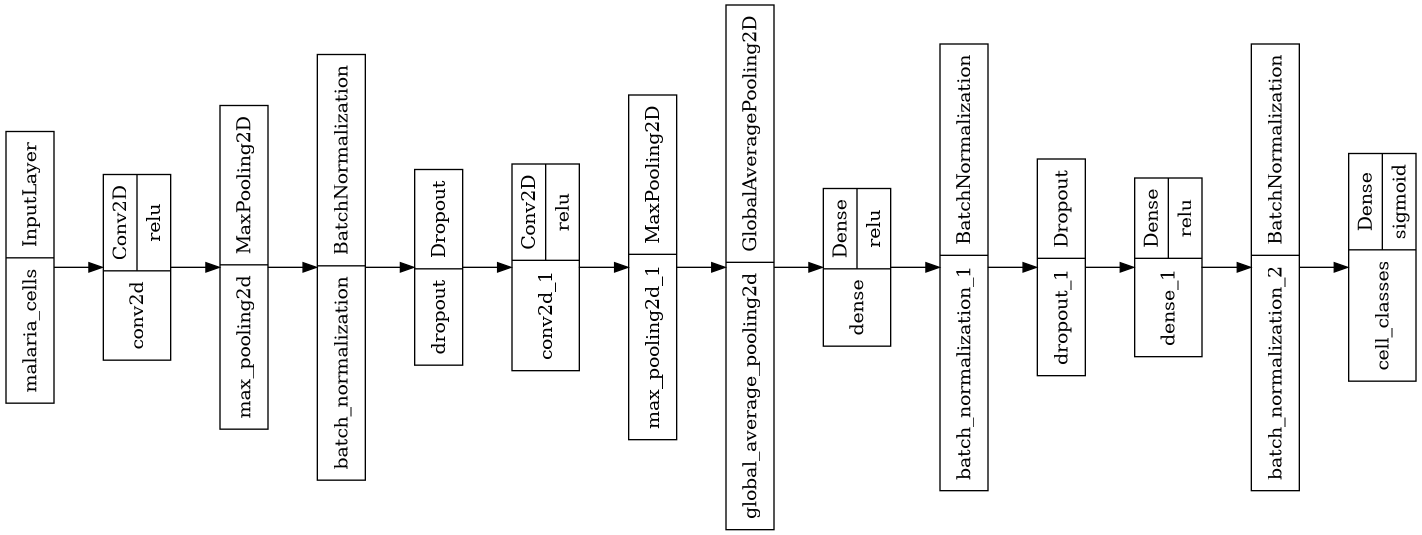

In [14]:
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model

input = Input(shape = (img_width, img_height, 3), dtype=tf.float32, name="malaria_cells")
X = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(input)
X = MaxPooling2D(pool_size = (2, 2))(X)
X = BatchNormalization()(X)
X = Dropout(0.3)(X)
X = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(X)
X = MaxPooling2D(pool_size = (2, 2))(X)

X = GlobalAveragePooling2D()(X)
X = Dense(512, activation="relu")(X)
X = BatchNormalization()(X)
X = Dropout(0.3)(X)
X = Dense(256, activation="relu")(X)
X = BatchNormalization()(X)
output = Dense(1, activation="sigmoid", name="cell_classes")(X)

model = Model(inputs=input, outputs=output)

In [16]:
plot_model = tf.keras.utils.plot_model(model, "model.png", show_layer_activations=True)
model.summary()

You must install pydot (`pip install pydot`) for `plot_model` to work.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ malaria_cells (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cell_classes (Dense)            │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,913 (808.25 KB)

 Trainable params: 205,249 (801.75 KB)

 Non-trainable params: 1,664 (6.50 KB)

In [17]:
optim = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer=optim, loss=loss, metrics=["accuracy"])

Training the model 

In [19]:
import os
import tensorflow as tf

epochs = 5

checkpoint_dir = os.path.join(os.getcwd(), 'checkpoints') # Define the directory to save checkpoints

os.makedirs(checkpoint_dir, exist_ok=True) # Confirm the directory exists

checkpoint_filepath = os.path.join(checkpoint_dir, 'model_checkpoint.weights.h5')

# Define the ModelCheckpoint callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=3, 
    min_delta=1e-3, 
    restore_best_weights=True)

# Fit the model with the callbacks
history = model.fit(
    training_data, 
    epochs= epochs, 
    validation_data=validation_data, 
    callbacks=[model_checkpoint_callback, early_stopping])


Epoch 1/5


c:\Users\user\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


603/603 ━━━━━━━━━━━━━━━━━━━━ 572s 936ms/step - accuracy: 0.6583 - loss: 0.6434 - val_accuracy: 0.5122 - val_loss: 0.5840
Epoch 2/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 475s 784ms/step - accuracy: 0.9210 - loss: 0.2426 - val_accuracy: 0.9370 - val_loss: 0.1770
Epoch 3/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 478s 790ms/step - accuracy: 0.9417 - loss: 0.1993 - val_accuracy: 0.9413 - val_loss: 0.1780
Epoch 4/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 474s 783ms/step - accuracy: 0.9421 - loss: 0.2003 - val_accuracy: 0.7977 - val_loss: 0.4323
Epoch 5/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 436s 721ms/step - accuracy: 0.9412 - loss: 0.1905 - val_accuracy: 0.9453 - val_loss: 0.1785


In [21]:
model.save('malaria-cnn-model2.keras')

In [22]:
model.evaluate(validation_data)

259/259 ━━━━━━━━━━━━━━━━━━━━ 79s 304ms/step - accuracy: 0.9366 - loss: 0.1777


[0.18057796359062195, 0.9364868402481079]

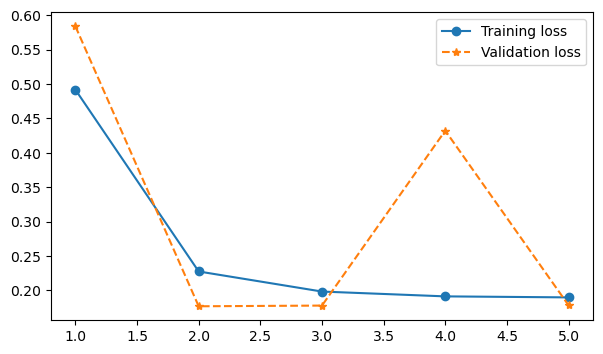

In [23]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["loss"], marker="o", label="Training loss")
ax.plot(range(1, epochs+1), history.history["val_loss"], marker="*", ls="--", label="Validation loss")
ax.legend()
plt.show()

Overfitting observed from 3rd to 5th epoch 

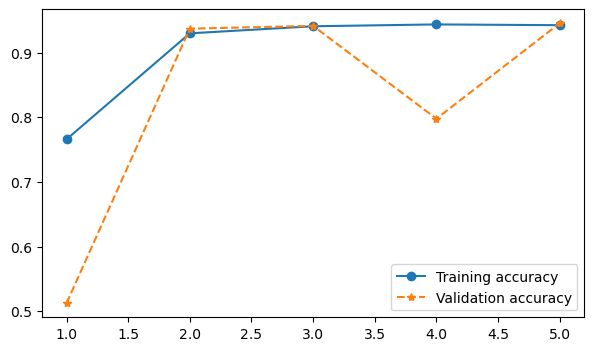

In [24]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["accuracy"], marker="o", label="Training accuracy")
ax.plot(range(1, epochs+1), history.history["val_accuracy"], marker="*", ls="--", label="Validation accuracy")
ax.legend()
plt.show()

In [25]:
y_pred_proba = model.predict(validation_data).flatten()
y_pred_classes = (y_pred_proba >= 0.5).astype(np.int32)

259/259 ━━━━━━━━━━━━━━━━━━━━ 84s 325ms/step


In [26]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def evaluate_random_image(path, ax):
    image = load_img(str(path), target_size=(img_width, img_height))
    img_arr = img_to_array(image) #convert image to numpy array as expected by model
    img_arr /= 255  #normalize by scaling from [0,255] to [0,1]
    pred = model.predict(img_arr.reshape(1, *img_arr.shape), verbose=0).flatten() 
    #reshapes the array to a 1D array by flattening. A batch dimension of 1,height,width,channels is added
    label = "Parasitised" if pred < 0.5 else "Uninfected"
    ax.imshow(img_arr, vmin=1, vmax=1)
    ax.set_title(f"{label} - {pred[0]:.2%}", size=10)
    ax.axis("off")

In [27]:
parasitized_path = list(data_dir.glob("Parasitized/*"))
uninfected_path = list(data_dir.glob("Uninfected/*"))

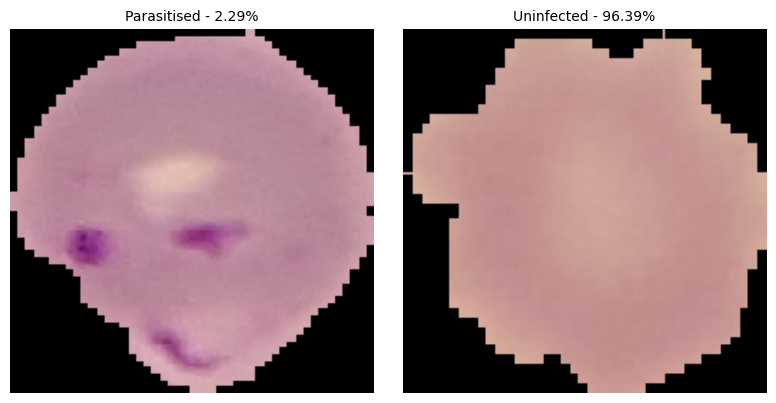

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
index = np.random.randint(len(parasitized_path))
evaluate_random_image(parasitized_path[index], ax1)
evaluate_random_image(uninfected_path[index], ax2)
plt.tight_layout()

Transfer Learning Using VGG19 Model

In [34]:
from tensorflow.keras.applications import VGG19

base_model = VGG19(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3))
base_model.trainable = False

base_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [35]:
input = Input(shape=(img_width, img_height, 3), dtype=tf.float32)
vgg_model = base_model(input)
X = Flatten()(vgg_model)
output = Dense(1, activation="sigmoid", name="cell_classes")(X)

model_2 = Model(inputs=input, outputs=output)
model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 4, 4, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cell_classes (Dense)            │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,032,577 (76.42 MB)

 Trainable params: 8,193 (32.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [36]:
optim = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy()

model_2.compile(optimizer=optim, loss=loss, metrics=["accuracy"])

In [37]:
epochs = 5
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, min_delta=1e-3, restore_best_weights=True)

history = model_2.fit(training_data, epochs=epochs, validation_data=validation_data, callbacks=[early_stopping])

Epoch 1/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 1571s 3s/step - accuracy: 0.8120 - loss: 0.4142 - val_accuracy: 0.8770 - val_loss: 0.3245
Epoch 2/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 1465s 2s/step - accuracy: 0.9004 - loss: 0.2571 - val_accuracy: 0.8801 - val_loss: 0.2946
Epoch 3/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 1435s 2s/step - accuracy: 0.9087 - loss: 0.2443 - val_accuracy: 0.8949 - val_loss: 0.2818
Epoch 4/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 1440s 2s/step - accuracy: 0.9179 - loss: 0.2233 - val_accuracy: 0.8986 - val_loss: 0.2765
Epoch 5/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 1475s 2s/step - accuracy: 0.9148 - loss: 0.2299 - val_accuracy: 0.8906 - val_loss: 0.3052


In [38]:
model_2.evaluate(validation_data)

259/259 ━━━━━━━━━━━━━━━━━━━━ 485s 2s/step - accuracy: 0.8916 - loss: 0.2895


[0.2830723822116852, 0.8998306393623352]

Based on the results upon evaluation of the two models, our model perfoms better than the VGG19 model 